# Imports:

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow import keras
from keras.layers import Embedding, Bidirectional, GRU, Dense, GlobalMaxPooling1D, SpatialDropout1D, Reshape, Input
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
import numpy as np
from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel
from typing import List
import tensorflow as tf
from sklearn.model_selection import KFold
from node2vec import Node2Vec
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import utils_harmful
import embeddings
import formating
import models
from sklearn.utils import class_weight
import wandb


In [79]:
import importlib
importlib.reload(utils_harmful)
importlib.reload(embeddings)
importlib.reload(formating)
importlib.reload(models)

<module 'models' from '/Users/anaconstantinescu/Documents/Ana/an_4/licenta/models.py'>

# Process Data:

In [62]:
# Extract tweets and labels 
df_en, y_labels = utils_harmful.process_dataset_exist2023("./dataset/training/EXIST2023_training.json")
df_tweets, labels = utils_harmful.process_dataset_final("./dataset/training/final_dataset.csv")
tweets, labels_hate = utils_harmful.hate_speech_dataset("./dataset/training/train.csv")

In [63]:
df_tweets = pd.concat([df_tweets, tweets])
labels = pd.concat([labels, labels_hate])

In [64]:
import nltk
nltk.download('stopwords')
df_tweets = formating.clean_text(df_tweets)
labels = labels

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anaconstantinescu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Analyze data

In [66]:
%%capture cap

for tweet in df_tweets:
    print(tweet)

with open('output.txt', 'w') as file:
    file.write(cap.stdout)

In [78]:
%%capture cap

for label in labels:
    print(label)

with open('output_labels.txt', 'w') as file:
    file.write(cap.stdout)

(3258,)


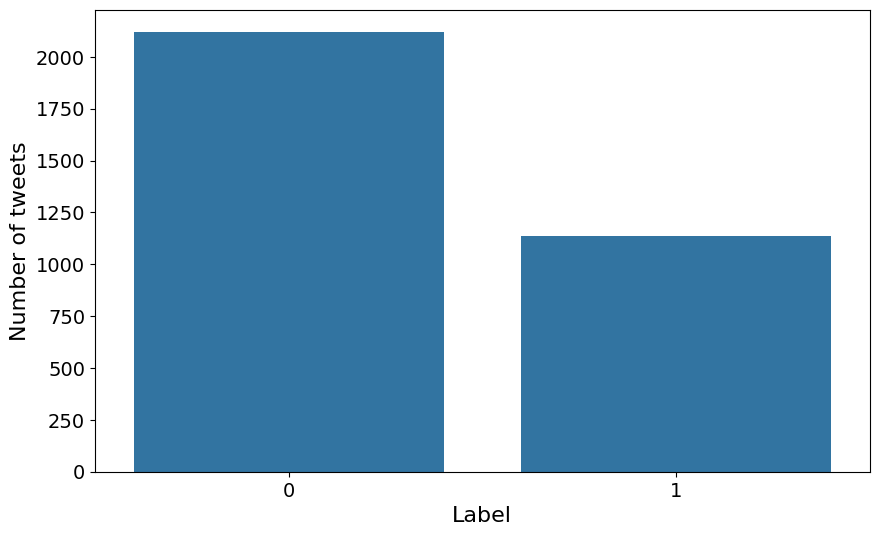

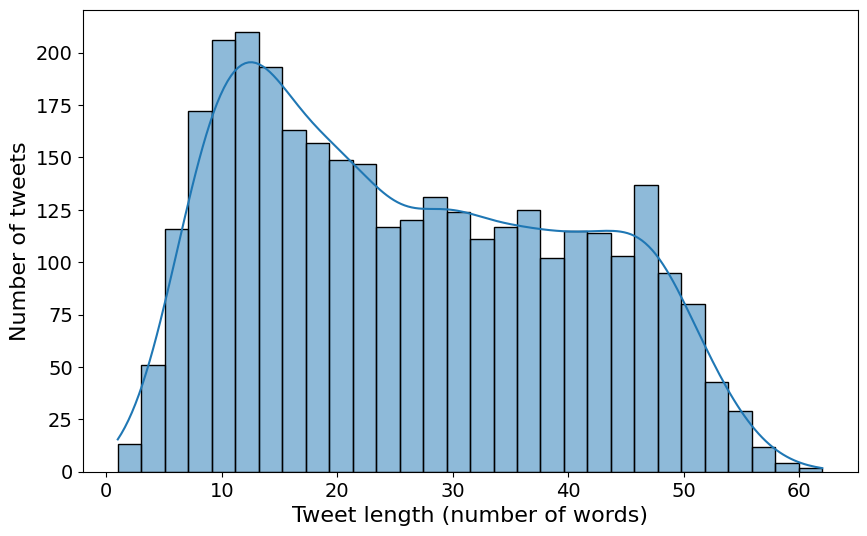

count    3258.000000
mean       26.297115
std        13.926695
min         1.000000
25%        14.000000
50%        24.000000
75%        38.000000
max        62.000000
Name: tweet, dtype: float64


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcularea distribuției label-urilor
label_distribution = labels.value_counts()

print(np.shape(labels))

# Afișarea distribuției label-urilor
plt.figure(figsize=(10, 6))
sns.countplot(x=labels, order=label_distribution.index)
# plt.title('Label distribution for Hate Speech Database', fontsize=16))
plt.xlabel('Label', fontsize=16)
plt.ylabel('Number of tweets', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
# Calcularea lungimii tweet-urilor
tweet_lenght= df_tweets.apply(lambda x: len(x.split()))

# Afișarea variației lungimii tweet-urilor
plt.figure(figsize=(10, 6))
sns.histplot(tweet_lenght, bins=30, kde=True)
# plt.title('Tweet length distribution for Hate Speech Database')
plt.xlabel('Tweet length (number of words)', fontsize=16)
plt.ylabel('Number of tweets', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Statistici descriptive pentru lungimea tweet-urilor
tweet_length_stats = tweet_lenght.describe()
print(tweet_length_stats)

55


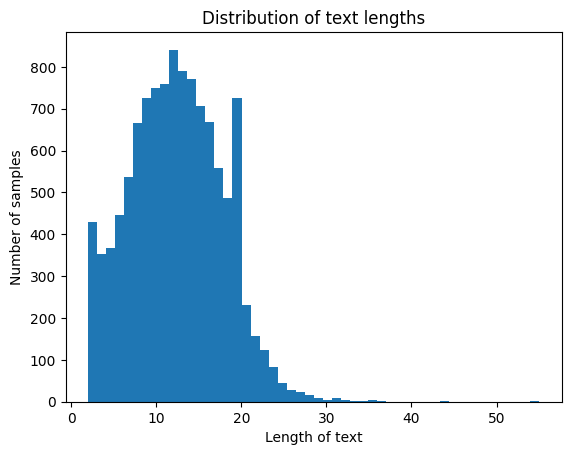

In [47]:
import matplotlib.pyplot as plt

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

text_lengths = [len(tokenizer.encode(tweet)) for tweet in df_tweets]
print(max(text_lengths))
plt.hist(text_lengths, bins=50)
plt.xlabel('Length of text')
plt.ylabel('Number of samples')
plt.title('Distribution of text lengths')
plt.show()

# Glove model train:

In [67]:
glove_embedding_dict = KeyedVectors.load_word2vec_format('glove.6B/glove.6B.50d.txt', binary=False)

In [47]:

max_sequence_length = 50
wordEmbeddings = embeddings.WordEmbeddings(max_sequence_length)

# Trained model with Word2vec, EarlyStpping and Cross Validation:

In [7]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
tweets_tokenized = df_tweets.apply(lambda tweet : word_tokenize(tweet))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anaconstantinescu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
from gensim.models import Word2Vec

# word2vec_model = Word2Vec(tweets_tokenized, vector_size=50, window=4, min_count=1, sg=1)
# word2vec_model.save('model.bin')

In [9]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.0001]
        },
        'batch_size': {
            'values': [32, 64]
        },
        'epochs': {
            'values': [40, 50]
        },
        'hidden_units': {
            'values': [32, 64]
        },
        'optimizator': {
            'values': ['adam', 'rmsprop']
        }
    }
}

In [10]:
# Tokenize tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_tweets) # Fit tokenizer on tweets
sequences = tokenizer.texts_to_sequences(df_tweets)  # Convert texts to sequences

# Pad sequences
X_pad = pad_sequences(sequences, maxlen=max_sequence_length)

# Build the embedding matrix
# embedding_matrix = wordEmbeddings.word2VecEmbeddings(word2vec_model.wv, 50)


In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_pad, labels, test_size=0.2, random_state=42, stratify=labels)


In [12]:
def word2vec_model(config=None):
    with wandb.init(config=config):
        config = wandb.config

        word2vec_model = Word2Vec(tweets_tokenized, vector_size=50, window=4, min_count=1, sg=1)
        embedding_matrix = wordEmbeddings.word2VecEmbeddings(word2vec_model.wv, 50)

        model = models.build_classif_gru_model_with_embedding_3(word2vec_model.wv, embedding_matrix, max_sequence_length, config.hidden_units, config.optimizator, config.learning_rate)

        early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=3, baseline=None)

        with tf.device('/device:GPU:0'): 
            history = utils_harmful.train_evaluate(model, X_train, X_val, y_train, y_val, callback=early_stopping, epoch_num=config.epochs, batch_size=config.batch_size)

            for epoch in range(len(history['loss'])):
                wandb.log({
                    "epoch": epoch,
                    "train_loss": history['loss'][epoch],
                    "train_accuracy": history['acc'][epoch],
                    "val_loss": history['val_loss'][epoch],
                    "val_accuracy": history['val_acc'][epoch]
                })

            plt.figure()
            plt.plot(history['loss'], label='Train Loss')
            plt.plot(history['val_loss'], label='Validation Loss')
            plt.title("Loss Over Epochs")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.savefig("loss_plot.png")
            wandb.log({"loss_plot": wandb.Image("loss_plot.png")})

In [ ]:
wandb.init(project="text_classification_sweep")
sweep_id = wandb.sweep(sweep_config, project="text_classification_sweep")
wandb.agent(sweep_id, function=word2vec_model, count=7)

# Trained model with Glove, EarlyStpping and Cross Validation:

## With Embedding Layer

In [68]:
# Tokenize tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_tweets) 
sequences = tokenizer.texts_to_sequences(df_tweets)  
word_index = tokenizer.word_index 

# Pad sequences
X_pad = pad_sequences(sequences, maxlen=max_sequence_length)
X_train, X_val, y_train, y_val = train_test_split(X_pad, labels, test_size=0.2, random_state=42, stratify=labels)


In [74]:
print(X_pad[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0   43 2454   30  198 1586
   86  119   41   90   20  215  468   13]


In [76]:
for word, i in word_index.items():
    if i == 2454:
        print(word)


insane


In [53]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

Epoch 1/20
362/362 [==============================] - 94s 221ms/step - loss: 0.6323 - accuracy: 0.6374 - val_loss: 0.4481 - val_accuracy: 0.8127
Epoch 2/20
362/362 [==============================] - 41s 112ms/step - loss: 0.4327 - accuracy: 0.8272 - val_loss: 0.4028 - val_accuracy: 0.8482
Epoch 3/20
362/362 [==============================] - 46s 126ms/step - loss: 0.3672 - accuracy: 0.8540 - val_loss: 0.3717 - val_accuracy: 0.8569
Epoch 4/20
362/362 [==============================] - 43s 119ms/step - loss: 0.3403 - accuracy: 0.8591 - val_loss: 0.3543 - val_accuracy: 0.8605
Epoch 5/20
362/362 [==============================] - 36s 100ms/step - loss: 0.3246 - accuracy: 0.8618 - val_loss: 0.3518 - val_accuracy: 0.8598
Epoch 6/20
362/362 [==============================] - 116s 322ms/step - loss: 0.3141 - accuracy: 0.8635 - val_loss: 0.3819 - val_accuracy: 0.8593
Epoch 7/20
362/362 [==============================] - 54s 148ms/step - loss: 0.3052 - accuracy: 0.8671 - val_loss: 0.3357 - val_a

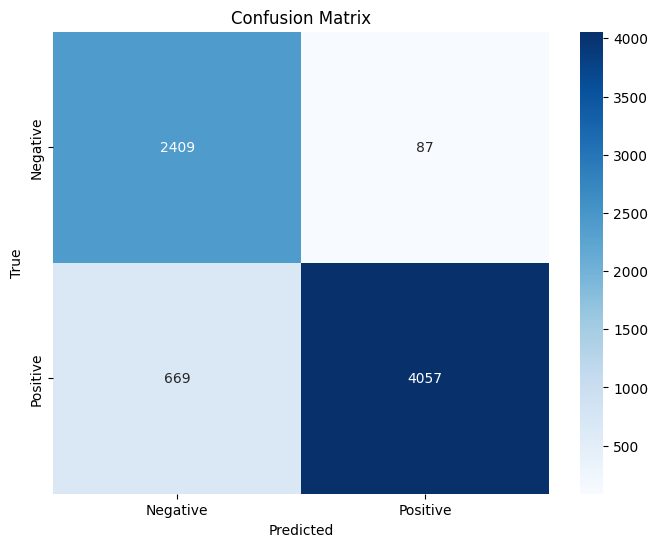

In [80]:

embedding_matrix = wordEmbeddings.gloveEmbeddings(tokenizer, glove_embedding_dict)

model = models.build_classif_gru_model_with_embedding(word_index, embedding_matrix, max_sequence_length, 64, 'rmsprop', 0.0001)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=3, baseline=None)

with tf.device('/device:GPU:0'): 
    # Iterate over each fold and evaluate
    utils_harmful.train_evaluate(model, X_train, X_val, y_train, y_val, callback=early_stopping, epoch_num = 20, batch_size=64, class_weights_dict = class_weight_dict)

In [52]:
model.save("model_glove.h5")

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Average Accuracy: 0.8142
Average Precision: 0.6553
Average Recall: 0.6378
Avearage F1: 0.6458 - GRU - MAxPool - Dropout - Dense - kfold?

 Accuracy: 0.7934
 Precision: 0.5913
 Recall: 0.7209
 F1: 0.6497 GRU - maxPool -dense - learning scheduler

## Without Embedding Layer

In [ ]:
max_sequence_length = 50

# Tokenize tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_tweets) # Fit tokenizer on tweets
sequences = tokenizer.texts_to_sequences(df_tweets)  # Convert texts to sequences
word_index = tokenizer.word_index # Get word index

# Pad sequences
X_pad = pad_sequences(sequences, maxlen=max_sequence_length)

# Initialize the embedding matrix
embedding_matrix = np.zeros((len(X_pad), max_sequence_length, max_sequence_length))

# Build the embedding matrix as a 3d matrix, each tweet having a list an array of word embeddings for each word
for i, seq in enumerate(X_pad):
    for j, word_index in enumerate(seq):
            embedding_matrix[i, j, :] = glove_embedding_dict[word_index]

# Build the BiGRU model
model = models.build_classif_gru_model(50)

early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=3, baseline=None)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

utils_harmful.train_evaluate(model, embedding_matrix, labels, callback=early_stopping, epoch_num = 50, batch_size=32)

Average Accuracy: 0.9669
Average Precision: 0.9525
Average Recall: 0.9558

# Hyperparameter Tuning: use Grid search:

In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# Function to create the model
def create_model(units, optimizer):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, 50, weights=[embedding_matrix], input_length=max_sequence_length, trainable=True))
    model.add(Bidirectional(GRU(units=units, return_sequences=True), input_shape=(None, 50)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define hyperparameters to tune
param_grid = {
    'model__units': [16, 32],
    'batch_size': [16, 32],
    'model__optimizer': ['adam', 'rmsprop'],
}

# Initialize StratifiedKFold for cross-validation
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.005)
grid = GridSearchCV(estimator=KerasClassifier(model=create_model, epochs=30),
                    param_grid=param_grid, scoring='accuracy', cv=5)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_pad, y_labels, callbacks=[early_stopping])

# Print the best parameters
print("Best Parameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)

# BERT:

In [17]:
import pickle

with open('X_bert_128.pkl', 'wb') as f:
    pickle.dump(X_bert, f)

In [31]:
import pickle

with open('X_robert_128.pkl', 'wb') as f:
    pickle.dump(X_roberta, f)

In [2]:
import pickle

with open('X_bert_128.pkl', 'rb') as f:
    X_bert = pickle.load(f)

2024-06-14 15:05:35.589284: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-06-14 15:05:35.589313: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-14 15:05:35.589331: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-14 15:05:35.589697: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-14 15:05:35.589877: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
X_bert = wordEmbeddings.bertEmbeddings(df_tweets)

# RoBERTa:

In [30]:

X_roberta = wordEmbeddings.RoBertaEmbeddings(df_tweets)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

# Trained model using BERT/RoBERTa Embedding Layer, EarlyStpping and Cross Validation:

In [54]:
if tf.is_tensor(X_bert):
    X_bert = X_bert.numpy()

X_train, X_val, y_train, y_val = train_test_split(X_bert, labels, test_size=0.2, random_state=42, stratify=labels)


In [63]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [62]:

def bert_roberta_evaluation(X_train, X_val, y_train, y_val, n_splits, epochs, batch_size, optimizator, hidden_units, lr) -> tuple:    
    model = models.build_classif_gru_model_3(768, gru_units=hidden_units, optimizator=optimizator, lr=lr)
    
    model.save_weights('weight_model.h5')

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, baseline=None)
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001)
    
    # histories =  utils_harmful.kfold_train_evaluate(model, X, y_labels, nr_splits=n_splits, callback=[reduce_lr, early_stopping], epoch_num=epochs)
    histories =  utils_harmful.train_evaluate(model, X_train, X_val, y_train, y_val, callback= early_stopping, epoch_num=epochs, batch_size=batch_size)

    model.save('bert_model.h5')
    return histories, model


In [ ]:
bert_roberta_evaluation(X_roberta, labels, n_splits=10, epochs=50)

Average Accuracy: 0.9650
Average Precision: 0.9490
Average Recall: 0.9514

Average Accuracy: 0.9538
Average Precision: 0.9108
Average Recall: 0.9322

Epoch 1/30
723/723 [==============================] - 19s 20ms/step - loss: 0.5830 - accuracy: 0.7036 - val_loss: 0.4878 - val_accuracy: 0.7850
Epoch 2/30
723/723 [==============================] - 19s 27ms/step - loss: 0.4664 - accuracy: 0.7851 - val_loss: 0.4263 - val_accuracy: 0.7999
Epoch 3/30
723/723 [==============================] - 16s 22ms/step - loss: 0.4388 - accuracy: 0.7963 - val_loss: 0.4709 - val_accuracy: 0.7767
Epoch 4/30
723/723 [==============================] - 16s 23ms/step - loss: 0.4248 - accuracy: 0.8019 - val_loss: 0.4216 - val_accuracy: 0.8058
Epoch 5/30
723/723 [==============================] - 15s 21ms/step - loss: 0.4176 - accuracy: 0.8055 - val_loss: 0.4204 - val_accuracy: 0.8049
Epoch 6/30
723/723 [==============================] - 15s 21ms/step - loss: 0.4129 - accuracy: 0.8086 - val_loss: 0.4354 - val_accuracy: 0.7975
Epoch 7/30
723/723 [==============================] - 16s 22ms/step - loss: 0.4067 - accuracy: 0.8140 - val_loss: 0.4074 - val_accuracy:

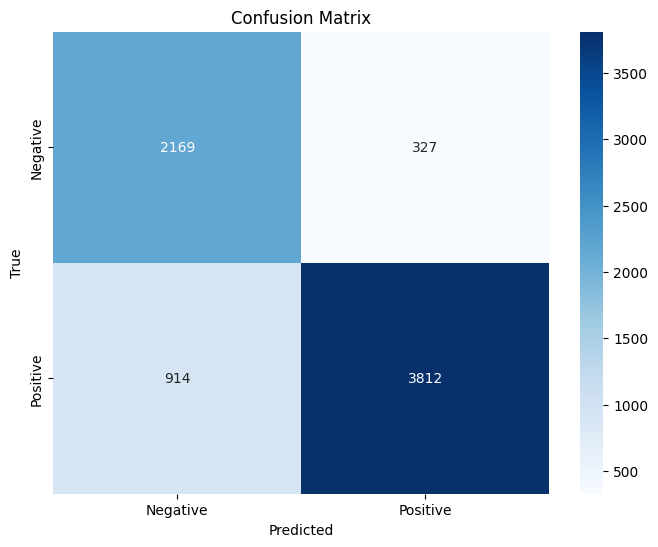

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [64]:
with tf.device('/device:GPU:0'): 
    histories, model = bert_roberta_evaluation(X_train, X_val, y_train, y_val,
                                                n_splits=5, epochs=30, batch_size=32, optimizator='adam',
                                                 hidden_units=32, lr=0.0001)
    

Accuracy: 0.8452
 Precision: 0.8661
 Recall: 0.9031
 F1: 0.8842 
 

 models.build_classif_gru_model(768)
 bert-embeddings- - fara stopwords, batch size 32, 30 epoci
 

In [41]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirect  (None, None, 64)          153984    
 ional)                                                          
                                                                 
 dropout_40 (Dropout)        (None, None, 64)          0         
                                                                 
 bidirectional_11 (Bidirect  (None, None, 32)          7872      
 ional)                                                          
                                                                 
 dropout_41 (Dropout)        (None, None, 32)          0         
                                                                 
 dense_7 (Dense)             (None, None, 1)           33        
                                                                 
Total params: 161889 (632.38 KB)
Trainable params: 161

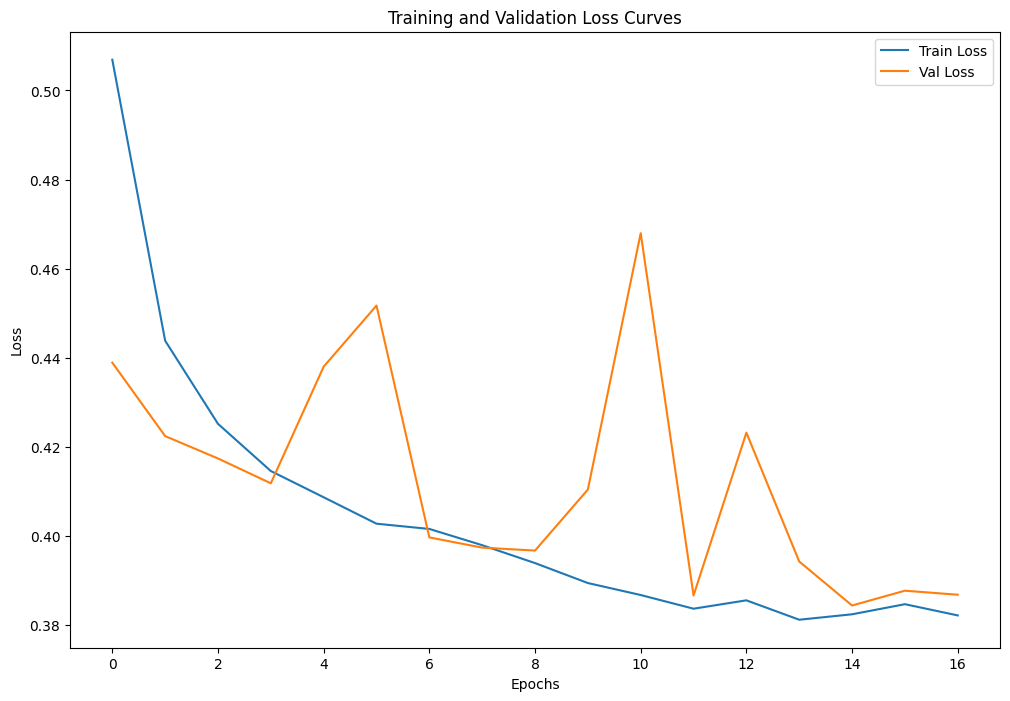

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirecti  (None, None, 32)          75456     
 onal)                                                           
                                                                 
 global_max_pooling1d_7 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 75489 (294.88 KB)
Trainable params: 75489 (294.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(histories['loss'], label=f'Train Loss')
plt.plot(histories['val_loss'], label=f'Val Loss')
    
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(model.summary())

Average Accuracy: 0.9730
Average Precision: 0.9624
Average Recall: 0.9576


Average Accuracy: 0.8708
Average Precision: 0.6668
Average Recall: 0.6584

Average Accuracy: 0.9647
Average Precision: 0.9511
Average Recall: 0.9334

Average Accuracy: 0.9602
Average Precision: 0.9246
Average Recall: 0.9246


Set date 2:

Average Accuracy: 0.9571
Average Precision: 0.9292
Average Recall: 0.9056 -gru-gru-dense-30

Average Accuracy: 0.9604
Average Precision: 0.9315
Average Recall: 0.9163 - gru - dense - 30


Average Accuracy: 0.9549
Average Precision: 0.9136
Average Recall: 0.9226 - gru - dens-drop-dense -50

Average Accuracy: 0.9562
Average Precision: 0.9264
Average Recall: 0.9073 - gru - dens-drop-dense -128

# Graph Embeddings:

## Create graph:

In [26]:
import networkx as nx

graph = nx.Graph()

# Add nodes for tweets
for tweet_id in df_en.index:
    graph.add_node(f"tweet_{tweet_id}")

# Add edges between tweets with mutual annotators
for annotator in df_en['annotators'].explode().unique():
    tweets_with_annotator = df_en[df_en['annotators'].apply(lambda x: annotator in x)].index
    for tweet1 in tweets_with_annotator:
        for tweet2 in tweets_with_annotator:
            if tweet1 != tweet2:
                common_annotators = len(set(df_en.at[tweet1, 'annotators']).intersection(df_en.at[tweet2, 'annotators']))
                cost = common_annotators
                graph.add_edge(f"tweet_{tweet1}", f"tweet_{tweet2}", cost=cost)

## Node2vec Embeddings:

In [27]:
def weighted_walk(graph, node, prev_node, p, q):
    
    weights = []  
    neighbors = [] 

    for neighbor, data in graph[node].items():
        # Consider the edge cost as the weight for each neighbor
        weight = data['cost'] if 'cost' in data else 1
        neighbors.append|(neighbor)
        if neighbor == prev_node:
            weights.append((weight / p))
        else:
            weights.extend(weight / q)
    
    weight_sum = sum(weights)

    # Calculate probabilities for each neighbor
    probabilities = [weight / weight_sum for weight in weights]

    # Choose next node based on probabilities
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]

    return next

# Node2Vec Embedding layer
graph_embedding_size = 50  # You can adjust this size

node2vec = Node2Vec(graph, dimensions=graph_embedding_size, walk_length=30, num_walks=200, workers=4)
node2vec._walk = weighted_walk  # Override default walk function with custom one
node2vec_model = node2vec.fit(window=10, min_count=1)

# Generate Node2Vec embeddings for tweets
node2vec_embeddings = np.array([node2vec_model.wv[f"tweet_{tweet_id}"] for tweet_id in df_en.index])
node2vec_embeddings = pad_sequences(node2vec_embeddings, maxlen=graph_embedding_size, dtype="float32", value=0, truncating="post", padding="post")

# expand  embeddings structure for later use
node2vec_embeddings = tf.concat(node2vec_embeddings, axis=0)
node2vec_embeddings = tf.expand_dims(node2vec_embeddings, axis=1)


Computing transition probabilities:   0%|          | 0/3258 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


# Trained model using BERT/RoBERTa/Glove + node2vec Embedding Layer, EarlyStpping and Cross Validation:

## BERT/RoBERTa + node2vec

In [31]:
from keras.layers import Concatenate

def train_model(model_type, model_name, X):
    # Load model and tokenizer
    if model_type == 'BERT':
        model_pretrain = TFBertModel.from_pretrained(model_name, trainable=False)
    elif model_type == 'RoBERTa':
        model_pretrain = TFRobertaModel.from_pretrained(model_name, trainable=False)

    # Concatenate embeddings Bert/Robert with graph embeddings
    X_combined = Concatenate(axis=-1)([X, node2vec_embeddings])

    model = Sequential()
    model.add(Bidirectional(GRU(units=16, return_sequences=True), input_shape=(None, model_pretrain.config.hidden_size + graph_embedding_size)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))

    callback = EarlyStopping(monitor='loss', patience=3, baseline=None)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train and evaluate model using k-fold cross-validation
    utils_harmful.kfold_train_evaluate(model, X_combined, y_labels, nr_splits=10, callback=early_stopping, epoch_num=100)

In [32]:
train_model('BERT', 'bert-base-uncased', X_bert)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Fold 1/10
Epoch 1/100
92/92 [==============================] - 7s 30ms/step - loss: 0.5943 - accuracy: 0.6859
Epoch 2/100
92/92 [==============================] - 1s 15ms/step - loss: 0.5155 - accuracy: 0.7432
Epoch 3/100
92/92 [==============================] - 2s 18ms/step - loss: 0.4695 - accuracy: 0.7694
Epoch 4/100
92/92 [==============================] - 1s 15ms/step - loss: 0.4550 - accuracy: 0.7783
Epoch 5/100
92/92 [==============================] - 2s 18ms/step - loss: 0.4333 - accuracy: 0.7923
Epoch 6/100
92/92 [==============================] - 2s 17ms/step - loss: 0.4392 - accuracy: 0.7892
Epoch 7/100
92/92 [==============================] - 1s 16ms/step - loss: 0.4175 - accuracy: 0.7998
Epoch 8/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3930 - accuracy: 0.8172
Epoch 9/100
92/92 [==============================] - 1s 14ms/step - loss: 0.3836 - accuracy: 0.8261
Epoch 10/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3642 - accura

Average Accuracy: 0.9767
Average Precision: 0.9652
Average Recall: 0.9681

In [33]:
train_model('RoBERTa', 'roberta-base', X_roberta)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Fold 1/10
Epoch 1/100
92/92 [==============================] - 7s 33ms/step - loss: 0.6401 - accuracy: 0.6392
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.5619 - accuracy: 0.6995
Epoch 3/100
92/92 [==============================] - 2s 17ms/step - loss: 0.4924 - accuracy: 0.7534
Epoch 4/100
92/92 [==============================] - 1s 15ms/step - loss: 0.4723 - accuracy: 0.7711
Epoch 5/100
92/92 [==============================] - 1s 15ms/step - loss: 0.4512 - accuracy: 0.7814
Epoch 6/100
92/92 [==============================] - 1s 16ms/step - loss: 0.4369 - accuracy: 0.7896
Epoch 7/100
92/92 [==============================] - 1s 14ms/step - loss: 0.4271 - accuracy: 0.7902
Epoch 8/100
92/92 [==============================] - 1s 14ms/step - loss: 0.4257 - accuracy: 0.8012
Epoch 9/100
92/92 [==============================] - 1s 16ms/step - loss: 0.4132 - accuracy: 0.7998
Epoch 10/100
92/92 [==============================] - 1s 14ms/step - loss: 0.4031 - accura

Average Accuracy: 0.9681
Average Precision: 0.9559
Average Recall: 0.9541


## GLOVE + node2vec:

In [32]:
# Combine GloVe and Node2Vec embeddings
combined_embeddings = np.concatenate((embedding_matrix, node2vec_embeddings), axis=1)

model = Sequential()
model.add(Bidirectional(GRU(units=32, return_sequences=True), input_shape=(max_sequence_length + 1, 50)))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, baseline=None)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

utils_harmful.kfold_train_evaluate(model, combined_embeddings, y_labels, nr_splits=10, callback=early_stopping, epoch_num=100)

Fold 1/10
Epoch 1/100
92/92 [==============================] - 6s 25ms/step - loss: 0.6444 - accuracy: 0.6511
Epoch 2/100
92/92 [==============================] - 2s 23ms/step - loss: 0.6209 - accuracy: 0.6569
Epoch 3/100
92/92 [==============================] - 2s 23ms/step - loss: 0.5992 - accuracy: 0.6729
Epoch 4/100
92/92 [==============================] - 2s 23ms/step - loss: 0.5803 - accuracy: 0.7046
Epoch 5/100
92/92 [==============================] - 2s 23ms/step - loss: 0.5647 - accuracy: 0.7135
Epoch 6/100
92/92 [==============================] - 2s 25ms/step - loss: 0.5442 - accuracy: 0.7282
Epoch 7/100
92/92 [==============================] - 2s 24ms/step - loss: 0.5306 - accuracy: 0.7408
Epoch 8/100
92/92 [==============================] - 2s 22ms/step - loss: 0.5106 - accuracy: 0.7551
Epoch 9/100
92/92 [==============================] - 2s 22ms/step - loss: 0.4945 - accuracy: 0.7647
Epoch 10/100
92/92 [==============================] - 2s 22ms/step - loss: 0.4786 - accura

Average Accuracy: 0.9660
Average Precision: 0.9534
Average Recall: 0.9381